<a href="https://colab.research.google.com/github/Pranav-Raj-05/Projects/blob/main/MultiMP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 58.7 MB/s eta 0:00:00


In [ ]:
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv \
    -f https://data.pyg.org/whl/torch-2.8.0+cu126.html
!pip install torch_geometric

Looking in links: https://data.pyg.org/whl/torch-2.8.0+cu126.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 77.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 131.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 70.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 58.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.1 MB/s eta 0:00:00


Device: cuda

Loading QM9 dataset (multi-target regression)...


Extracting data/QM9/raw/qm9.zip
Processing...
100%|██████████| 133885/133885 [02:30<00:00, 890.77it/s] 
Done!


Using targets: ['μ (dipole moment)', 'α (polarizability)', 'HOMO', 'LUMO', 'HOMO-LUMO gap']

Loading MUTAG dataset (classification)...


Processing...
Done!



Starting multi-target training...


Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]


FINAL MODEL EVALUATION

--- Molecular Property Prediction (Regression) ---
  - μ (dipole moment)        : MAE = 0.6034, R² = 0.6900
  - α (polarizability)       : MAE = 2.5719, R² = 0.7528
  - HOMO                     : MAE = 0.1532, R² = 0.8836
  - LUMO                     : MAE = 0.1660, R² = 0.9689
  - HOMO-LUMO gap            : MAE = 0.2180, R² = 0.9453

--- Toxicity Prediction (Classification) ---
  - MUTAG Accuracy: 0.7368

✅ Saved multi-target plot to 'results_plots/'


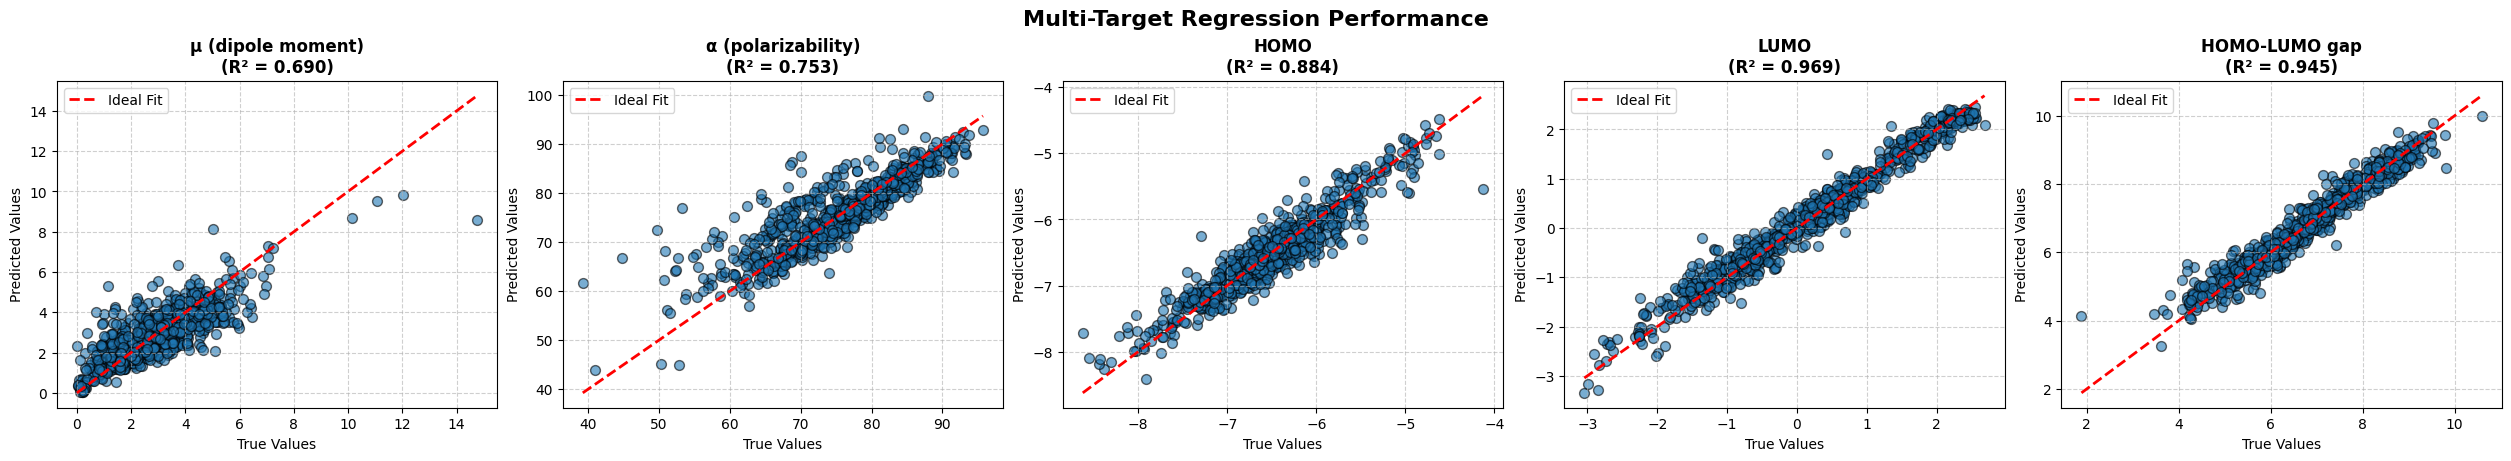

In [ ]:
# -------------------------
# Multi-target Drug Discovery Training Script
# -------------------------
import os
import warnings
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from torch_geometric.datasets import QM9, TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool, GraphNorm, GINConv, SAGEConv

warnings.filterwarnings("ignore", category=UserWarning, message="It is not recommended to directly access the internal storage format")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -------------------------
# Load datasets
# -------------------------
print("\nLoading QM9 dataset (multi-target regression)...")
dataset = QM9(root="data/QM9")

property_names = [
    'μ (dipole moment)', 'α (polarizability)', 'HOMO', 'LUMO', 'HOMO-LUMO gap',
    'R² (electronic extent)', 'ZPVE', 'U₀ (internal energy)', 'U (internal energy)',
    'H (enthalpy)', 'G (free energy)', 'Cv (heat capacity)',
    'U₀ atomization', 'U atomization', 'H atomization', 'G atomization',
    'A (rot. const. A)', 'B (rot. const. B)', 'C (rot. const. C)'
]

# -------------------------
# Select multiple targets
# -------------------------
target_indices = [0, 1, 2, 3, 4]  # You can change number of properties
print(f"Using targets: {[property_names[i] for i in target_indices]}")

all_original_targets = dataset.data.y[:, target_indices].clone().numpy()
scaler = StandardScaler()
scaled_targets = scaler.fit_transform(all_original_targets)
dataset.data.y = torch.tensor(scaled_targets, dtype=torch.float32)

# Shuffle + splits
dataset = dataset.shuffle()
train_dataset_reg = dataset[:10000]
val_dataset_reg = dataset[10000:11000]
test_dataset_reg = dataset[11000:12000]

train_loader_reg = DataLoader(train_dataset_reg, batch_size=64, shuffle=True)
val_loader_reg = DataLoader(val_dataset_reg, batch_size=64)
test_loader_reg = DataLoader(test_dataset_reg, batch_size=64)

# -------------------------
# MUTAG dataset for classification
# -------------------------
print("\nLoading MUTAG dataset (classification)...")
mutag = TUDataset(root="data/MUTAG", name="MUTAG")
torch.manual_seed(42)
mutag = mutag.shuffle()
split1 = int(0.8 * len(mutag))
split2 = int(0.9 * len(mutag))
train_dataset_c, val_dataset_c, test_dataset_c = mutag[:split1], mutag[split1:split2], mutag[split2:]
train_loader_c = DataLoader(train_dataset_c, batch_size=32, shuffle=True)
val_loader_c = DataLoader(val_dataset_c, batch_size=32)
test_loader_c = DataLoader(test_dataset_c, batch_size=32)

# -------------------------
# Models
# -------------------------
class GINReg(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, dropout=0.25):
        super().__init__()
        nn1 = nn.Sequential(nn.Linear(in_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim))
        nn2 = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim))
        nn3 = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim))
        nn4 = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim))
        self.conv1 = GINConv(nn1)
        self.norm1 = GraphNorm(hidden_dim)
        self.conv2 = GINConv(nn2)
        self.norm2 = GraphNorm(hidden_dim)
        self.conv3 = GINConv(nn3)
        self.norm3 = GraphNorm(hidden_dim)
        self.conv4 = GINConv(nn4)
        self.norm4 = GraphNorm(hidden_dim)
        self.lin1 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.lin2 = nn.Linear(hidden_dim, out_dim)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.norm1(self.conv1(x, edge_index)))
        x = F.relu(self.norm2(self.conv2(x, edge_index)))
        x = F.relu(self.norm3(self.conv3(x, edge_index)))
        x = F.relu(self.norm4(self.conv4(x, edge_index)))
        x = global_mean_pool(x, batch)
        x = F.relu(self.lin1(x))
        x = self.dropout(x)
        return self.lin2(x)

class SAGEClf(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, dropout=0.6):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, hidden_dim)
        self.norm1 = GraphNorm(hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.norm2 = GraphNorm(hidden_dim)
        self.lin1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.dropout = nn.Dropout(dropout)
        self.lin2 = nn.Linear(hidden_dim // 2, out_dim)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.norm1(self.conv1(x, edge_index)))
        x = F.relu(self.norm2(self.conv2(x, edge_index)))
        x = global_mean_pool(x, batch)
        x = F.relu(self.lin1(x))
        x = self.dropout(x)
        return self.lin2(x)

# -------------------------
# Hyperparameters
# -------------------------
hidden_dim = 256
epochs = 100
num_targets = len(target_indices)

model_reg = GINReg(in_dim=dataset.num_node_features, hidden_dim=hidden_dim, out_dim=num_targets).to(device)
model_clf = SAGEClf(in_dim=mutag.num_node_features, hidden_dim=hidden_dim, out_dim=mutag.num_classes).to(device)

opt_reg = torch.optim.AdamW(model_reg.parameters(), lr=5e-4, weight_decay=1e-5)
opt_clf = torch.optim.AdamW(model_clf.parameters(), lr=1e-3, weight_decay=1e-4)

# Class weights for MUTAG
train_labels = np.array([data.y.item() for data in train_dataset_c])
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
loss_reg_fn = nn.HuberLoss()
loss_clf_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

scheduler_reg = torch.optim.lr_scheduler.CosineAnnealingLR(opt_reg, T_max=epochs)
scheduler_clf = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_clf, 'max', patience=10, factor=0.7)

use_amp = device.type == 'cuda'
# FIX: Corrected GradScaler instantiation. It does not take a device argument.
scaler_reg = torch.amp.GradScaler(enabled=use_amp)
scaler_clf = torch.amp.GradScaler(enabled=use_amp)

# -------------------------
# Early stopping
# -------------------------
def save_checkpoint(model, optimizer, path):
    torch.save({'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, path)

def load_checkpoint(model, path):
    ckpt = torch.load(path, map_location=device)
    model.load_state_dict(ckpt['model_state_dict'])

class EarlyStopping:
    def __init__(self, mode='min', patience=15, delta=1e-4, path='checkpoint.pt'):
        self.mode = mode
        self.patience = patience
        self.delta = delta
        self.best = None
        self.counter = 0
        self.path = path
        self.is_better = (lambda a,b: a < b - self.delta) if mode=='min' else (lambda a,b: a > b + self.delta)

    def step(self, metric, model, optimizer):
        if self.best is None or self.is_better(metric, self.best):
            self.best = metric
            self.counter = 0
            save_checkpoint(model, optimizer, self.path)
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

es_reg = EarlyStopping(mode='min', patience=15, path='best_model_reg.pt')
es_clf = EarlyStopping(mode='max', patience=15, path='best_model_clf.pt')

# -------------------------
# Training / evaluation
# -------------------------
def train_epoch(loader, model, optimizer, loss_fn, scaler, is_regression=False):
    model.train()
    total_loss = 0.0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        with torch.amp.autocast(device_type=device.type, enabled=use_amp):
            out = model(data.x, data.edge_index, data.batch)
            target = data.y.view_as(out) if is_regression else data.y
            loss = loss_fn(out, target)
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        total_loss += float(loss.item()) * data.num_graphs
    return total_loss / len(loader.dataset)

def eval_reg(loader, model, scaler):
    model.eval()
    y_true_scaled_list, y_pred_scaled_list = [], []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            y_true_scaled_list.append(data.y.cpu())
            y_pred_scaled_list.append(out.cpu())
    y_true_scaled = torch.cat(y_true_scaled_list).numpy()
    y_pred_scaled = torch.cat(y_pred_scaled_list).numpy()
    scaled_mae = mean_absolute_error(y_true_scaled, y_pred_scaled, multioutput='raw_values')
    y_true_orig = scaler.inverse_transform(y_true_scaled)
    y_pred_orig = scaler.inverse_transform(y_pred_scaled)
    mae_orig = mean_absolute_error(y_true_orig, y_pred_orig, multioutput='raw_values')
    r2 = r2_score(y_true_orig, y_pred_orig, multioutput='raw_values')
    return mae_orig, scaled_mae, r2, y_true_orig, y_pred_orig

def eval_clf(loader, model):
    model.eval()
    ys, preds, outs = [], [], []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            pred = out.argmax(dim=1)
            ys.append(data.y.cpu())
            preds.append(pred.cpu())
            outs.append(out.cpu())
    y_true = torch.cat(ys).numpy()
    y_pred = torch.cat(preds).numpy()
    y_scores = F.softmax(torch.cat(outs), dim=1)[:, 1].numpy() if outs and outs[0].shape[1] > 1 else np.zeros_like(y_true, dtype=float)
    acc = (y_true == y_pred).mean()
    return acc, y_true, y_pred, y_scores

# -------------------------
# Training loop
# -------------------------
history_reg = {'loss': [], 'val_mae': [], 'val_mae_scaled': [], 'val_r2': []}
history_clf = {'loss': [], 'val_acc': []}

print("\nStarting multi-target training...")
for epoch in tqdm(range(1, epochs+1), desc="Training Epochs"):
    tr_loss_reg = train_epoch(train_loader_reg, model_reg, opt_reg, loss_reg_fn, scaler=scaler_reg, is_regression=True)
    val_mae, val_mae_scaled, val_r2, _, _ = eval_reg(val_loader_reg, model_reg, scaler)
    scheduler_reg.step()
    history_reg['loss'].append(tr_loss_reg)
    history_reg['val_mae'].append(val_mae)
    history_reg['val_mae_scaled'].append(val_mae_scaled)
    history_reg['val_r2'].append(val_r2)

    tr_loss_clf = train_epoch(train_loader_c, model_clf, opt_clf, loss_clf_fn, scaler=scaler_clf, is_regression=False)
    val_acc, _, _, _ = eval_clf(val_loader_c, model_clf)
    scheduler_clf.step(val_acc)
    history_clf['loss'].append(tr_loss_clf)
    history_clf['val_acc'].append(val_acc)

    if es_reg.step(val_mae_scaled.mean(), model_reg, opt_reg) and es_clf.step(val_acc, model_clf, opt_clf):
        print(f"\nEarly stopping triggered at epoch {epoch}")
        break

if os.path.exists('best_model_reg.pt'):
    load_checkpoint(model_reg, 'best_model_reg.pt')
if os.path.exists('best_model_clf.pt'):
    load_checkpoint(model_clf, 'best_model_clf.pt')

# -------------------------
# Final evaluation
# -------------------------
test_mae, test_mae_scaled, test_r2, y_true_reg, y_pred_reg = eval_reg(test_loader_reg, model_reg, scaler)
test_acc, y_true_clf, y_pred_clf, y_scores_clf = eval_clf(test_loader_c, model_clf)

print("\n" + "="*50)
print("FINAL MODEL EVALUATION")
print("="*50)
print("\n--- Molecular Property Prediction (Regression) ---")
for i, name in enumerate([property_names[j] for j in target_indices]):
    print(f"  - {name:<25}: MAE = {test_mae[i]:.4f}, R² = {test_r2[i]:.4f}")
print("\n--- Toxicity Prediction (Classification) ---")
print(f"  - MUTAG Accuracy: {test_acc:.4f}")
print("="*50)

# -------------------------
# Plot results for each property
# -------------------------
os.makedirs('results_plots', exist_ok=True)
fig, axes = plt.subplots(1, num_targets, figsize=(5 * num_targets, 4.5), constrained_layout=True)
fig.suptitle("Multi-Target Regression Performance", fontsize=16, fontweight='bold')
if num_targets == 1:
    axes = [axes] # Ensure axes is always iterable
for i, ax in enumerate(axes):
    prop_name = property_names[target_indices[i]]
    ax.scatter(y_true_reg[:, i], y_pred_reg[:, i], alpha=0.6, edgecolors='k', s=50)
    ax.plot([y_true_reg[:, i].min(), y_true_reg[:, i].max()],
            [y_true_reg[:, i].min(), y_true_reg[:, i].max()], 'r--', lw=2, label='Ideal Fit')
    ax.set_title(f"{prop_name}\n(R² = {test_r2[i]:.3f})", fontweight='bold')
    ax.set_xlabel("True Values")
    ax.set_ylabel("Predicted Values")
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend()
plt.savefig('results_plots/multi_target_performance.png', dpi=300)
print("\n✅ Saved multi-target plot to 'results_plots/'")

